#Aps360 Satellite Object Detection Project

Provided with a satellite view of image the classifer model must identify the object. The model is trained with 46 different classes.

In [ ]:
#####Run this code at the end of the project completion  #####
%%shell
jupyter nbconvert --to html "/content/Start_Here_APS360_Project.ipynb"

[NbConvertApp] Converting notebook /content/Start_Here_APS360_Project.ipynb to html
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/widgetsdatatypefilter.py:71: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn(
[NbConvertApp] Writing 9405291 bytes to /content/Start_Here_APS360_Project.html


In [ ]:
# Other notebooks were also used for the Project
# Please see group google drive

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import zipfile
import matplotlib.pyplot as plt
from PIL import Image

Automate Splitting dataset onto Folder, unzip, and divide the dataset into train/Val/test set


In [ ]:
#Access to dataset Folder
from google.colab import drive
drive.mount('/content/drive')
# Create a folder in My Drive called aps360_project_data
# Download  the MRLS dataset from here: https://data.mendeley.com/datasets/7j9bv9vwsx/3
# Upload this data as a zip file into aps360_project_data as a zip file , Must Rename the Zip file to MRLSNetFolder
# Manually create a folder called original_data underneath aps360_project_data
# under aps360_project_data create 3 more subfolders called Train_MLRS, Val_MLRS, and Test_MLRS

Mounted at /content/drive


The commented out code was used to split the data into train / val /test folders for the MLRSNet Dataset


In [ ]:
##########Run Only once ################################
'''
#Rename the zip file uploaded to drive under aps360_project_data to MLRSNetFolder,
# Open original_data after running the code and modify the large folder name to MRLSNet
#Unzip file in lab3_data_folder
with zipfile.ZipFile('/content/drive/My Drive/aps360_project_data/MRLSNetFolder.zip', 'r') as reference:
  reference.extractall('/content/drive/My Drive/aps360_project_data/original_data')
'''

"\n#Rename the zip file uploaded to drive under aps360_project_data to MLRSNetFolder,\n# Open original_data after running the code and modify the large folder name to MRLSNet\n#Unzip file in lab3_data_folder\nwith zipfile.ZipFile('/content/drive/My Drive/aps360_project_data/MRLSNetFolder.zip', 'r') as reference:\n  reference.extractall('/content/drive/My Drive/aps360_project_data/original_data')\n"

In [ ]:
##########Run Only once ################################
'''
import os # Get access to files inside drive
import shutil # To copy files/ images
orig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'
train_path = '/content/drive/My Drive/aps360_project_data/Train_MLRS/'
val_path = '/content/drive/My Drive/aps360_project_data/Val_MLRS/'
test_path = '/content/drive/My Drive/aps360_project_data/Test_MLRS/'
# Add folder paths for each of the classes
classes = [ 'airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard', 'snowberg','sparse_residential_area','stadium',
            'storage_tank','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']

# do for train val and test
for label in classes:
    label_path_t = os.path.join(train_path, label)
    label_path_v = os.path.join(val_path, label)
    label_path_test = os.path.join(test_path, label)
    if not os.path.exists(label_path_t):
        os.mkdir(label_path_t)
    if not os.path.exists(label_path_v):
        os.mkdir(label_path_v)
    if not os.path.exists(label_path_test):
        os.mkdir(label_path_test)
    os.makedirs(label_path_test, exist_ok=True)
  '''

"\nimport os # Get access to files inside drive\nimport shutil # To copy files/ images\norig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'\ntrain_path = '/content/drive/My Drive/aps360_project_data/Train_MLRS/'\nval_path = '/content/drive/My Drive/aps360_project_data/Val_MLRS/'\ntest_path = '/content/drive/My Drive/aps360_project_data/Test_MLRS/'\n# Add folder paths for each of the classes\nclasses = [ 'airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,\n           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',\n            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',\n            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',\n            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard', 'snowberg','sparse_residential_a

In [ ]:
'''
!pip install rarfile
'''

'\n!pip install rarfile\n'

In [ ]:
#############Run Only Once
'''
import os
import shutil
orig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'
import rarfile
orig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'
train_path = '/content/drive/My Drive/aps360_project_data/Train_MLRS/'
val_path = '/content/drive/My Drive/aps360_project_data/Val_MLRS/'
test_path = '/content/drive/My Drive/aps360_project_data/Test_MLRS/'
rarfile.UNRAR_TOOL = "/usr/bin/unrar"  # Set the path to the unrar tool
#Split the data 60%, 20% , 20% (enough of data so 60 -percent train, 20-val and  20- test)
# Take 60% of images in each class (eg. 60% of aiplane images and put in Train, 20% of airplane images put in Val etc.. This is done for all classes)
#classes # 'sparse_residential_area',snowberg
           # 'storage_tank' omitted
for part in classes:

    sub_path = os.path.join(orig_path, part)
    os.makedirs(sub_path, exist_ok=True)
    rarfile.RarFile(sub_path +'.rar').extractall(orig_path)
    files = os.listdir(os.path.join(orig_path, part))
    for index, img in enumerate(files):
        source_path = os.path.join(orig_path, part, img)
        if index < 0.6 * len(files):
            dest_path = os.path.join(train_path, part)
            shutil.copy(source_path,dest_path)
            #print(dest_path)
        elif index < 0.8 * len(files):
            dest_path = os.path.join(val_path, part)
            shutil.copy(source_path,dest_path)
            #print(dest_path)
        else:
            dest_path = os.path.join(test_path, part)
            shutil.copy(source_path,dest_path)
            #print(dest_path)
  #The dataset is shared will be under aps360_project_data
  #All memebers that have the aps360_project_data under shared with me folder may make a short cut to access it
      # - Steps: https://towardsdatascience.com/simplify-file-sharing-44bde79a8a18
'''

'\nimport os\nimport shutil\norig_path = \'/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images\'\nimport rarfile\norig_path = \'/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images\'\ntrain_path = \'/content/drive/My Drive/aps360_project_data/Train_MLRS/\'\nval_path = \'/content/drive/My Drive/aps360_project_data/Val_MLRS/\'\ntest_path = \'/content/drive/My Drive/aps360_project_data/Test_MLRS/\'\nrarfile.UNRAR_TOOL = "/usr/bin/unrar"  # Set the path to the unrar tool\n#Split the data 60%, 20% , 20% (enough of data so 60 -percent train, 20-val and  20- test)\n# Take 60% of images in each class (eg. 60% of aiplane images and put in Train, 20% of airplane images put in Val etc.. This is done for all classes)\n#classes # \'sparse_residential_area\',snowberg\n           # \'storage_tank\' omitted\nfor part in classes:\n\n    sub_path = os.path.join(orig_path, part)\n    os.makedirs(sub_path, exist_ok=True)\n    rarfile.RarFile(sub_path +\'.rar\').ext

In [ ]:
################ Run only once , used for debugging, errors due to hidden files -- now resolved
'''
import os
import shutil
#Find hidden folders using this
#ls -a '/content/drive/My Drive/aps360_project_data/Train_MLRS'

def remove_specific_folders(directory, folder_names):
    for root, dirs, files in os.walk(directory, topdown=False):
        for d in dirs:
            if d in folder_names:
                folder_path = os.path.join(root, d)
                shutil.rmtree(folder_path, ignore_errors=True)

# Usage:
hidden_folders_to_delete = ['storage_tan', 'storage_tank', 'sparse_residential_area (1)', 'snowberg', 'snowberg (1)']
#hidden_folders_to_delete = ['snowberg (1)']

remove_specific_folders('/content/drive/My Drive/aps360_project_data/Test_MLRS', hidden_folders_to_delete)  # Replace with your desired directory path
'''

"\nimport os\nimport shutil\n#Find hidden folders using this\n#ls -a '/content/drive/My Drive/aps360_project_data/Train_MLRS'\n\ndef remove_specific_folders(directory, folder_names):\n    for root, dirs, files in os.walk(directory, topdown=False):\n        for d in dirs:\n            if d in folder_names:\n                folder_path = os.path.join(root, d)\n                shutil.rmtree(folder_path, ignore_errors=True)\n\n# Usage:\nhidden_folders_to_delete = ['storage_tan', 'storage_tank', 'sparse_residential_area (1)', 'snowberg', 'snowberg (1)']\n#hidden_folders_to_delete = ['snowberg (1)']\n\nremove_specific_folders('/content/drive/My Drive/aps360_project_data/Test_MLRS', hidden_folders_to_delete)  # Replace with your desired directory path\n"

In [ ]:
#Small dataset

import os
import shutil
import random
orig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'
train_path = '/content/drive/My Drive/aps360_project_data/Train_MLRS/'
val_path = '/content/drive/My Drive/aps360_project_data/Val_MLRS/'
test_path = '/content/drive/My Drive/aps360_project_data/Test_MLRS/'

train_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_train/'
val_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Val/'
test_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Test/'
# Add folder paths for each of the classes
classes = [ 'airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard','stadium','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']

#total number of classes are 46
#Create sub_folders eg. Train with all 46 classes under train have airplane, airport etc..
# do for train val and test
'''
for label in classes:
    label_path_t = os.path.join(train_path_mid_size, label)
    label_path_v = os.path.join(val_path_mid_size, label)
    label_path_test = os.path.join(test_path_mid_size, label)
    print(label_path_t)
    print(label_path_v)
    print(label_path_test)
    if not os.path.exists(label_path_t):
        os.mkdir(label_path_t)
       print(label_path_t)
    if not os.path.exists(label_path_v):
        os.mkdir(label_path_v)
        print(label_path_v)
    if not os.path.exists(label_path_test):
        os.mkdir(label_path_test)
        print(label_path_test)
    os.makedirs(label_path_t, exist_ok=True)
'''


'\nfor label in classes:\n    label_path_t = os.path.join(train_path_mid_size, label)\n    label_path_v = os.path.join(val_path_mid_size, label)\n    label_path_test = os.path.join(test_path_mid_size, label)\n    print(label_path_t)\n    print(label_path_v)\n    print(label_path_test)\n    if not os.path.exists(label_path_t):\n        os.mkdir(label_path_t)\n       print(label_path_t)\n    if not os.path.exists(label_path_v):\n        os.mkdir(label_path_v)\n        print(label_path_v)\n    if not os.path.exists(label_path_test):\n        os.mkdir(label_path_test)\n        print(label_path_test)\n    os.makedirs(label_path_t, exist_ok=True)\n'

In [ ]:
#Small dataset

import os
import shutil
import random
orig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'
train_path = '/content/drive/My Drive/aps360_project_data/Train_MLRS/'
val_path = '/content/drive/My Drive/aps360_project_data/Val_MLRS/'
test_path = '/content/drive/My Drive/aps360_project_data/Test_MLRS/'

train_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_train/'
val_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Val/'
test_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Test/'
# Add folder paths for each of the classes
classes = ['airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard','stadium','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']



import os
import random
import shutil

'''
###### Run Only Once: Completed ##########
# Get a list of all subdirectories (classes) in the train_path folder
class_names = os.listdir(train_path)
def copy_images_to_midSize_dataset(original_train_val_or_test_path, target_path,num_images):
 # Iterate over each class
  classes = ['airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard','stadium','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']
  for class_name in classes:
       class_dir = os.path.join(original_train_val_or_test_path, class_name)
       all_images = os.listdir(class_dir)

       random.shuffle(all_images)

       selected_images = all_images[:num_images]

       for image in selected_images:
          src = os.path.join(class_dir, image)
          dest = os.path.join(target_path, class_name, image)
          shutil.copy(src, dest)
'''
#copy_images_to_midSize_dataset(train_path,train_path_mid_size,200)

#copy_images_to_midSize_dataset(val_path,val_path_mid_size,100)
#copy_images_to_midSize_dataset(test_path,test_path_mid_size,100)

print("Images copied successfully!")


Images copied successfully!


In [ ]:
#Will need this for later (using the ImageFolder)
# At this point the data is stored in train/val /test folders and use ImageFolder to extract images
# The paths may vary for each individual --> since the dataset is in the shared with me folder
import os
orig_path = '/content/drive/My Drive/aps360_project_data/original_data/MLRSNet/Images'
train_path = '/content/drive/My Drive/aps360_project_data/Train_MLRS'
val_path = '/content/drive/My Drive/aps360_project_data/Val_MLRS'
test_path = '/content/drive/My Drive/aps360_project_data/Test_MLRS'
# Add folder paths for each of the classes
classes = [ 'airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard','stadium','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']

transformation_normalization = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_ImageFolder = torchvision.datasets.ImageFolder(train_path, transform=transformation_normalization)
val_ImageFolder = torchvision.datasets.ImageFolder(val_path, transform=transformation_normalization)
test_ImageFolder = torchvision.datasets.ImageFolder(test_path, transform=transformation_normalization)

print("No. Images in train", len(train_ImageFolder), "No. Images in val:",len(val_ImageFolder), " No. Images in test:", len(test_ImageFolder))


train_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_train/'
val_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Val/'
test_path_mid_size = '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Test/'
# Add folder paths for each of the classes
classes = [ 'airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard','stadium','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']

transformation_normalization = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_ImageFolder_midsize = torchvision.datasets.ImageFolder(train_path_mid_size, transform=transformation_normalization)
val_ImageFolder_midsize = torchvision.datasets.ImageFolder(val_path_mid_size, transform=transformation_normalization)
test_ImageFolder_midsize = torchvision.datasets.ImageFolder(test_path_mid_size, transform=transformation_normalization)

print("MidSize dataset: No. Images in train", len(train_ImageFolder_midsize), "No. Images in val:",len(val_ImageFolder_midsize), " No. Images in test:", len(test_ImageFolder_midsize))

No. Images in train 61377 No. Images in val: 20453  No. Images in test: 20447
MidSize dataset: No. Images in train 8598 No. Images in val: 4300  No. Images in test: 4300


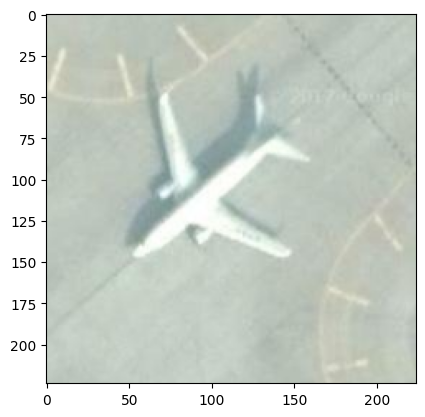

In [ ]:
#Transform.resize parameter
# For one Image is done here:  (then do for entire dataset Once done)
img = Image.open('/content/drive/My Drive/aps360_project_data/Train_MLRS/' + 'airplane/airplane_01060.jpg')
##can also crop Image
cropped_version = transforms.functional.center_crop(img, output_size=[224])
#for square resize
transformType = transforms.Resize(224)
#Another way to Resize
resize = transforms.functional.resize(img, size=[224])
resizedImage = transformType(img)
plt.imshow(resizedImage)

# Data Loading for the Small Dataset (about 4000 images)
(smaller dataset than the first one so faster training time)

In [ ]:
classes = [
    "airplane",
    "airport",
    "bareland",
    "baseball_diamond",
    "basketball_court",
    "beach",
    "bridge",
    "chaparral",
    "cloud",
    "commercial_area",
    "dense_residential_area",
    "desert",
    "eroded_farmland",
    "farmland",
    "forest",
    "freeway",
    "golf_course",
    "ground_track_field",
    "harbor&port",
    "industrial_area",
    "intersection",
    "island",
    "lake",
    "meadow",
    "mobile_home_park",
    "mountain",
    "overpass",
    "park",
    "parking_lot",
    "parkway",
    "railway",
    "railway_station",
    "river",
    "roundabout",
    "shipping_yard",
    "snowberg",
    "sparse_residential_area",
    "stadium",
    "storage_tank",
    "swimming_pool",
    "tennis_court",
    "terrace",
    "transmission_tower",
    "vegetable_greenhouse",
    "wetland",
    "wind_turbine"
]
small_dataset_path = '/content/drive/My Drive/aps360_project_data/small_dataset/small'
train_path_for_dataset = '/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS'
val_path_for_dataset = '/content/drive/My Drive/aps360_project_data/small_dataset/Val_MLRS'
test_path_for_dataset = '/content/drive/My Drive/aps360_project_data/small_dataset/Test_MLRS'
import os
import shutil

In [ ]:
'''

# Run Only Once  #
### Add class named Folders inside the small dataset folders for train/val/test   ####

for label in classes:
    label_path_t = os.path.join(train_path_for_dataset, label)
    label_path_v = os.path.join(val_path_for_dataset, label)
    label_path_test = os.path.join(test_path_for_dataset, label)
    if not os.path.exists(label_path_t):
        os.mkdir(label_path_t)
    if not os.path.exists(label_path_v):
        os.mkdir(label_path_v)
    if not os.path.exists(label_path_test):
        os.mkdir(label_path_test)
    os.makedirs(label_path_test, exist_ok=True)
'''

In [ ]:
def generate_small_dataset_given_orig(orig):
  for part in classes:
      # small dataset path contains a folder with classes as folders (each class = part)
      files = os.listdir(os.path.join(orig, part))
      for index, img in enumerate(files):
        if (index < 70):
          source_path = os.path.join(orig, part, img)
          if (index < (0.6 * 70)):
              dest_path = os.path.join(train_path_for_dataset, part)
              shutil.copy(source_path,dest_path)
              print(dest_path)
          elif (index < (0.8 * 70)):
              dest_path = os.path.join(val_path_for_dataset, part)
              shutil.copy(source_path,dest_path)
              print(dest_path)
          elif (index  < 70):
              dest_path = os.path.join(test_path_for_dataset, part)
              shutil.copy(source_path,dest_path)
              print(dest_path)


In [ ]:
# Run only Once #
#generate_small_dataset_given_orig(small_dataset_path)

/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS/airplane
/content/drive/My Drive/aps360_project_data/small_dataset/Train_

In [ ]:
############### Run this cell only when small dataset is used for testing purposes #####################
# For large dataset only run corresponding cells above

transformation_normalization = transforms.Compose(
        [transforms.Resize((224,224)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#small dataset image folders

train_ImageFolder = torchvision.datasets.ImageFolder(train_path_for_dataset, transform=transformation_normalization)
val_ImageFolder = torchvision.datasets.ImageFolder(val_path_for_dataset, transform=transformation_normalization)
test_ImageFolder = torchvision.datasets.ImageFolder(test_path_for_dataset, transform=transformation_normalization)

print("No. Images in train", len(train_ImageFolder), "No. Images in val:",len(val_ImageFolder), " No. Images in test:", len(test_ImageFolder))


No. Images in train 1932 No. Images in val: 644  No. Images in test: 643


Dataset

In [ ]:
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_path, transform=resize_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

# Initialize variables to hold sum and squared sum
mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0

# Iterate through the dataset to compute mean and std
for images, _ in (train_loader):
    images = images.view(images.size(0), images.size(1), -1)  # Flatten the images
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += images.size(0)

# Calculate the mean and std
mean /= n_samples
std /= n_samples

print(f"Mean: {mean}")
print(f"Std: {std}")
transformation_normalization = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),                 # Convert the image to a tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize the RGB channels
])

train_ImageFolder = datasets.ImageFolder(train_path, transform=transformation_normalization)
val_ImageFolder = datasets.ImageFolder(val_path, transform=transformation_normalization)
test_ImageFolder = datasets.ImageFolder(test_path, transform=transformation_normalization)

example_img_name = os.listdir(train_path)[3]
img_path = os.path.join(train_path, example_img_name)
img = Image.open(img_path)
normalized_img = transformation_normalization(img)

# Convert tensors to images for visualization
original_img = transforms.ToPILImage()(img)
normalized_img = normalized_img.permute(1, 2, 0).numpy()
normalized_img = (normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min())


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')  # Hide the axis

plt.subplot(1, 2, 2)
plt.imshow(normalized_img)
plt.title('Normalized Image')
plt.axis('off')  # Hide the axis

plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Mean: tensor([0.3936, 0.4056, 0.3824])
Std: tensor([0.1324, 0.1225, 0.1163])


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/My Drive/aps360_project_data/Train_MLRS/baseball_diamond'

##Adaptive Median Filter

In [ ]:

#img = Image.open('/path.png')

#gray_img = img.convert('L')

def stageA_function(Zmin, Zmax, Zmed, Zxy,SMax,x_center, y_center,x_curr_pixel, y_curr_pixel,img_with_padding, curr_size, resulting_img):
              A1 = Zmed - Zmin
              A2 = Zmed - Zmax
              edge_to_center_dist =  divmod(SMax, 2)[0]
              if A1 > 0 and A2 < 0:
                resulting_img[x_curr_pixel, y_curr_pixel] = stageB_AMF(Zxy, Zmin, Zmax, resulting_img, x_curr_pixel, y_curr_pixel, Zmed)
              else:
                  SMax = min(SMax + 2, curr_size)
                  Sxy = img_with_padding[x_center - edge_to_center_dist: x_center + edge_to_center_dist+ 1, y_center- edge_to_center_dist: y_center + edge_to_center_dist+ 1]
                  resulting_img[x_curr_pixel, y_curr_pixel] = np.median(Sxy)

              return resulting_img[x_curr_pixel, y_curr_pixel]

def stageB_AMF(Zxy, Zmin, Zmax, resulting_img, x_curr, y_curr, Zmed ):

    B1 = Zxy - Zmin
    B2 = Zxy - Zmax

    if B1 > 0 and B2 < 0:
        resulting_img[x_curr, y_curr] = Zxy
    else:
        resulting_img[x_curr, y_curr] = Zmed

    return resulting_img[x_curr, y_curr]



def AdaptiveMedianFilter(img, SMax=7):
    if(len(img.shape) == 1):
      pad_amount =  divmod(SMax, 2)[0] # integer part of division only
      total_padding = 2 * pad_amount
      first_dim =img.shape[0]
      second_dim = img.shape[1]
      img_with_padding = np.zeros((first_dim+ total_padding, second_dim + total_padding))
      currentSize = 1 # Gray scale Image
      img_with_padding[pad_amount:-pad_amount, pad_amount:-pad_amount] = img

      resulting_img = np.zeros(img)

      for x in range(img.shape[0]): # x, y are current pixels
          for y in range(img.shape[1]):
              edge_to_center_dist =  divmod(SMax, 2)[0]
              x_center = x + edge_to_center_dist #center of window
              y_center = y + edge_to_center_dist
              #The window size must center x_center, y_center
                                #x_center - edge_to_center_dist = x and similarily y_center - edge_to_center_dist = y
              Sxy = img_with_padding[x: x_center + edge_to_center_dist + 1, y: y_center + edge_to_center_dist+ 1]

              Zmin, Zmax, Zmed, Zxy = np.min(Sxy),np.max(Sxy),np.median(Sxy),img[x_center, y_center]
              stageA_function(Zmin, Zmax, Zmed, Zxy,SMax,x_center, y_center,x, y,img_with_padding, currentSize, resulting_img)
              #Stage A function also calls stage B function too
      return resulting_img


#AlexNet Architecture

Use Transfer Learning to achieve this

In [ ]:
#Use transfer learning
# Pre-trained AlexNet's features
import torchvision.models
#load network with trained network
alexnet = torchvision.models.alexnet(pretrained=True)
import numpy as np
'''
categories = [ 'airplane','airport', 'bareland', 'baseball_diamond','basketball_court','beach','bridge' ,
           'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland',
            'farmland','forest','freeway', 'golf_course','ground_track_field', 'harbor&port','industrial_area',
            'intersection','island','lake','meadow','mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway',
            'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard','stadium','swimmimg_pool','tennis_court','terrace','transmission_tower','vegetable_greenhouse','wetland','wind_turbine']

alexNet_train_path = '/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Train' (will not be used since it is not resized)

alexnet_val_path ='/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Validation'
alexnet_test_path ='/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Test'
'''

categories = [
    "airplane",
    "airport",
    "bareland",
    "baseball_diamond",
    "basketball_court",
    "beach",
    "bridge",
    "chaparral",
    "cloud",
    "commercial_area",
    "dense_residential_area",
    "desert",
    "eroded_farmland",
    "farmland",
    "forest",
    "freeway",
    "golf_course",
    "ground_track_field",
    "harbor&port",
    "industrial_area",
    "intersection",
    "island",
    "lake",
    "meadow",
    "mobile_home_park",
    "mountain",
    "overpass",
    "park",
    "parking_lot",
    "parkway",
    "railway",
    "railway_station",
    "river",
    "roundabout",
    "shipping_yard",
    "snowberg",
    "sparse_residential_area",
    "stadium",
    "storage_tank",
    "swimming_pool",
    "tennis_court",
    "terrace",
    "transmission_tower",
    "vegetable_greenhouse",
    "wetland",
    "wind_turbine"
]

small_dataset_path = '/content/drive/My Drive/aps360_project_data/small_dataset/small'
train_path_for_dataset = '/content/drive/My Drive/aps360_project_data/small_dataset/Train_MLRS'
val_path_for_dataset = '/content/drive/My Drive/aps360_project_data/small_dataset/Val_MLRS'
test_path_for_dataset = '/content/drive/My Drive/aps360_project_data/small_dataset/Test_MLRS'
import os
import shutil

In [ ]:
#Save pre-trained features as tensors in a folder specified by alexNet_train/val/test_paths Function
#Send each dataLoader in batches of 1 (1 image at a time to save computed features)
  # Older version, larger dataset Used here
dataLoaderTrain = torch.utils.data.DataLoader(train_ImageFolder, batch_size=1, shuffle=True)
dataLoaderVal = torch.utils.data.DataLoader(val_ImageFolder, batch_size=1, shuffle=True)
dataLoaderTest = torch.utils.data.DataLoader(test_ImageFolder, batch_size=1, shuffle=True)


In [ ]:
def save_computed_features(dataLoader, path):

  index = 0

  for images, label in iter(dataLoader):
      features = alexnet.features(images)
      features_tensor = torch.from_numpy(features.detach().numpy())
      full_path = path + '/' + str(categories[label]) + '/tensor_' + str(index)
      print(full_path)
      os.makedirs(full_path, exist_ok=True)
      index += 1
      torch.save(features_tensor.squeeze(0),full_path  + '.tensor')


print("Successful definition and dataLoaded")

def size_of_tensor(path_to_tensor):
  torch_creation=torch.load(path_to_tensor)
  return torch_creation.size()

import os
from PIL import Image


Successful definition and dataLoaded


In [ ]:
#!rm '/content/drive/My Drive/aps360_project_data/mid_size_dataset/MLRS_Train/airport/airport_01108.jpg'


In [ ]:
##Run Only Once
alexNet_train_path = '/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Train'
alexNet_test_path = '/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Test'
alexNet_val_path = '/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Val'


#save_computed_features(dataLoaderTrain,alexNet_train_path)
#save_computed_features(dataLoaderTest,alexNet_test_path)
#save_computed_features(dataLoaderVal,alexNet_val_path)

In [ ]:
#Print out the size of a tensor
size_of_tensor('/content/drive/My Drive/aps360_project_data/AlexNetPre_trained/Test/desert/tensor_13669.tensor')


torch.Size([256, 7, 7])

In [ ]:
## Small Dataset

alexNet_train_path_small = '/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train'
alexNet_test_path_small = '/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test'
alexNet_val_path_small = '/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val'
'''
save_computed_features(dataLoaderTrain,alexNet_train_path_small)
print("completed")
'''

/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/snowberg/tensor_0
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/mountain/tensor_1
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/bareland/tensor_2
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/freeway/tensor_3
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/river/tensor_4
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/vegetable_greenhouse/tensor_5
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/dense_residential_area/tensor_6
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/mobile_home_park/tensor_7
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Train/forest/tensor_8
/content/drive/My Drive/aps360_project_data/small_dataset/AlexN

In [ ]:
#save_computed_features(dataLoaderTest,alexNet_test_path_small)
print("completed")

/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/river/tensor_0
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/snowberg/tensor_1
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/farmland/tensor_2
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/transmission_tower/tensor_3
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/storage_tank/tensor_4
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/eroded_farmland/tensor_5
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/mobile_home_park/tensor_6
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/parkway/tensor_7
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Test/vegetable_greenhouse/tensor_8
/content/drive/My Drive/aps360_project_data/small_dataset/AlexN

In [ ]:
#save_computed_features(dataLoaderVal,alexNet_val_path_small)
print("completed")

/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/sparse_residential_area/tensor_0
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/wetland/tensor_1
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/bareland/tensor_2
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/dense_residential_area/tensor_3
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/meadow/tensor_4
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/sparse_residential_area/tensor_5
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/golf_course/tensor_6
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/intersection/tensor_7
/content/drive/My Drive/aps360_project_data/small_dataset/AlexNet_preTrained_Val/bareland/tensor_8
/content/drive/My Drive/aps360_project_data/small_dataset/Ale

In [ ]:
# Classification Model After using pre-trained weights for Alexnet
#Now will train the AlexNet Fully connected layers
#Model:
torch.manual_seed(10) # set the random seed
from math import floor

class classificationWithAlexNet(nn.Module):
    def __init__(self):
        super(classificationWithAlexNet, self).__init__()
        self.name = "classificationWithAlexNet"

        self.layer1 = nn.Linear(256*6*6, 190)
        self.layer2 = nn.Linear(190, 98)
        self.layer3 = nn.Linear(98, 46) # 43 for larger dataset since removed few classes

    def forward(self, inputImg):
        #print(inputImg.shape)
        flattened_tensor = inputImg.view(-1, 256*6*6)
        layer_first = F.relu(self.layer1(flattened_tensor))
        layer_second = F.relu(self.layer2(layer_first))
        output = self.layer3(layer_second)
        output = output.squeeze(1)
       #output = F.softmax(output)
        return  F.softmax(output, dim=1)
        # Computing the correct input size into the Fully Connected Layer

    '''# for t-SNE
    def featuresTSNE(self, inputImg):
        #print(inputImg.shape)
        flattened_tensor = inputImg.view(-1, 256*6*6)
        layer_first = F.relu(self.layer1(flattened_tensor))
        layer_second = F.relu(self.layer2(layer_first))
        output = self.layer3(layer_second)
        output = output.squeeze(1)
        return output
      '''

In [ ]:
torch.manual_seed(10) # set the random seed
from math import floor

class alexNetWithDropOut(nn.Module):
    def __init__(self):
        super(alexNetWithDropOut, self).__init__()
        self.name = "alexNetWithDropOut"

        self.layer1 = nn.Linear(256*6*6, 190)
        self.layer2 = nn.Linear(190, 98)
        self.layer3 = nn.Linear(98, 46) # 43 for larger dataset since removed few classes
        self.dropout = nn.Dropout(0.25) # same for all the layers
    def forward(self, inputImg):
        #print(inputImg.shape)
        flattened_tensor = inputImg.view(-1, 256*6*6)
        layer_first = F.relu(self.layer1(self.dropout(flattened_tensor)))
        layer_second = F.relu(self.layer2(self.dropout(layer_first)))
        output = self.layer3(self.dropout(layer_second))
        output = output.squeeze(1)
       #output = F.softmax(output)
        return  F.softmax(output, dim=1)
        # Computing the correct input size into the Fully Connected Layer



In [ ]:
model = classificationWithAlexNet()

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
#output = model(features)
#prob = F.softmax(output)

#Data Loading into DatasetFolder first
'''
alexNet_train_path = '/content/drive/My Drive/aps360_project_data/resizedAndAlexNet/Train'
alexnet_val_path ='/content/drive/My Drive/aps360_project_data/resizedAndAlexNet/Val'
alexnet_test_path ='/content/drive/My Drive/aps360_project_data/resizedAndAlexNet/Test'
'''
# use either the large or the small_dataset

# Here small dataset is used:
# For large dataset, use alexNet_train_path, alexnet_val_path, alexnet_test_path
data_set_folder_train = torchvision.datasets.DatasetFolder(alexNet_train_path_small, loader=torch.load, extensions=('.tensor'))

data_set_folder_val = torchvision.datasets.DatasetFolder(alexNet_val_path_small, loader=torch.load, extensions=('.tensor'))
data_set_folder_test = torchvision.datasets.DatasetFolder(alexNet_test_path_small, loader=torch.load, extensions=('.tensor'))
# Alternative way to load  is shown below (but instead will be using datasetFolder)
train_data_loader = torch.utils.data.DataLoader(data_set_folder_train, batch_size=64,
                                           num_workers=1, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(data_set_folder_val, batch_size=64,
                                           num_workers=1, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(data_set_folder_test, batch_size=64,
                                           num_workers=1, shuffle=True)

print("Successful loading")


Successful loading


In [ ]:
def train_test_val_Accuracy(model, batch_size, type_of_data = "Train"):
    if (type_of_data == "Train"):
        data = data_set_folder_train
    elif(type_of_data == "Val"):
        data = data_set_folder_val
    elif(type_of_data == "Test"): #Only used to calculate test accuracy at the end
        data = data_set_folder_test #Will not be used during training as the model should not train on the test dataset

    correct = 0
    total = 0
    use_cuda = True
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_with_transfer_learning(model, data, batch_size=27, learning_rate= 0.0999, num_epochs=30):
    torch.manual_seed(1000) # to ensure consistency in calculations

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss() #Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Use SGD with momentum worked better than Adam Optimizer here
    iters, losses, train_acc,train_err, train_loss, val_acc, val_acc_best = [], [], [], [], [], [], []
    start_time = time.time()

    use_cuda = True

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        val_acc_curr_best = 0

        print("Epoch: ", epoch + 1)
        for imgs, labels in iter(train_loader):
            #Use GPU for faster results
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)            # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            n += 1
            losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(train_test_val_Accuracy(model, batch_size, "Train")) # compute training accuracy
        curr_val_acc =train_test_val_Accuracy(model, batch_size, "Val")
        val_acc.append(curr_val_acc)  # compute validation accuracy
        if (val_acc[-1] > val_acc_curr_best):
            val_acc_curr_best = val_acc[-1]
            val_acc_best.append(val_acc_curr_best) # For particular  Epoch
        total_train_loss += loss.item()
        total_epoch += len(labels)

        print(( "So Far Best Validation Accuracy: {} Train Accuracy: {}, Validation Accuracy: {} ").format(
                   train_acc[-1],
                   val_acc[-1], val_acc_best[-1]))

        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)

    # plotting
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    plt.title("Training Curve")
    plt.plot(range(1, num_epochs + 1), train_acc, label="Train")
    plt.plot(range(1, num_epochs + 1), val_acc, label="Validation")
    plt.xlabel("Epoch Number")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    # Find the epoch with the best val_acc_best[]
    final_best_val_acc = max(val_acc_best)
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Best Validation Accuracy: {}".format(final_best_val_acc))

CUDA is not available.  Training on CPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.11490683229813664 Train Accuracy: 0.08229813664596274, Validation Accuracy: 0.08229813664596274 
Epoch:  2
So Far Best Validation Accuracy: 0.13302277432712215 Train Accuracy: 0.11024844720496894, Validation Accuracy: 0.11024844720496894 
Epoch:  3
So Far Best Validation Accuracy: 0.3090062111801242 Train Accuracy: 0.2593167701863354, Validation Accuracy: 0.2593167701863354 
Epoch:  4
So Far Best Validation Accuracy: 0.37577639751552794 Train Accuracy: 0.3338509316770186, Validation Accuracy: 0.3338509316770186 
Epoch:  5
So Far Best Validation Accuracy: 0.37732919254658387 Train Accuracy: 0.33229813664596275, Validation Accuracy: 0.33229813664596275 
Epoch:  6
So Far Best Validation Accuracy: 0.39492753623188404 Train Accuracy: 0.34627329192546585, Validation Accuracy: 0.34627329192546585 
Epoch:  7
So Far Best Validation Accuracy: 0.38198757763975155 Train Accuracy: 0.33695652173913043, Validatio

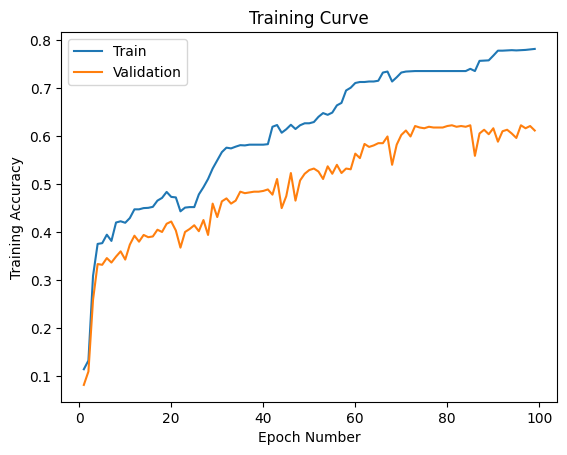

Final Training Accuracy: 0.7815734989648033
Final Validation Accuracy: 0.6118012422360248
Best Validation Accuracy: 0.6226708074534162


In [ ]:
# Train Output fully connected layers
use_cuda = True

model = classificationWithAlexNet()
ALNC = alexnet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
#train(model,data_set_folder_train, learning_rate=0.1, batch_size=64, num_epochs=5)
train_with_transfer_learning(model, data_set_folder_train,learning_rate = 0.1, batch_size=64, num_epochs=99)

In [ ]:
# Train Output fully connected layers
use_cuda = True

model_v2 = classificationWithAlexNet()
ALNC = alexnet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Lower batch Size
train_with_transfer_learning(model_v2, data_set_folder_train,learning_rate = 0.1, batch_size=32, num_epochs=200)
# Stopped training this model since validation accuracy started to decrease and plateau at a small number

CUDA is not available.  Training on CPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.12370600414078675 Train Accuracy: 0.09782608695652174, Validation Accuracy: 0.09782608695652174 
Epoch:  2
So Far Best Validation Accuracy: 0.18788819875776397 Train Accuracy: 0.16614906832298137, Validation Accuracy: 0.16614906832298137 
Epoch:  3
So Far Best Validation Accuracy: 0.2644927536231884 Train Accuracy: 0.2391304347826087, Validation Accuracy: 0.2391304347826087 
Epoch:  4
So Far Best Validation Accuracy: 0.3307453416149068 Train Accuracy: 0.2779503105590062, Validation Accuracy: 0.2779503105590062 
Epoch:  5
So Far Best Validation Accuracy: 0.34109730848861286 Train Accuracy: 0.296583850931677, Validation Accuracy: 0.296583850931677 
Epoch:  6
So Far Best Validation Accuracy: 0.42132505175983437 Train Accuracy: 0.37577639751552794, Validation Accuracy: 0.37577639751552794 
Epoch:  7
So Far Best Validation Accuracy: 0.36749482401656314 Train Accuracy: 0.3136645962732919, Validation Accu

KeyboardInterrupt: 

In [ ]:

def train_test_val_Accuracy_with_dropout(model, batch_size, type_of_data = "Train"):

    if (type_of_data == "Train"):
        data = data_set_folder_train
    elif(type_of_data == "Val"):
        data = data_set_folder_val
    elif(type_of_data == "Test"): #Only used to calculate test accuracy at the end
        data = data_set_folder_test #Will not be used during training as the model should not train on the test dataset

    correct = 0
    total = 0
    model.eval()
    use_cuda = True
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_with_transfer_learning_with_dropout(model, data, batch_size=27, learning_rate= 0.0999, num_epochs=30):
    torch.manual_seed(1000) # to ensure consistency in calculations

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss() #Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Use SGD with momentum worked better than Adam Optimizer here
    iters, losses, train_acc,train_err, train_loss, val_acc, val_acc_best = [], [], [], [], [], [], []
    start_time = time.time()

    use_cuda = True

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        val_acc_curr_best = 0

        print("Epoch: ", epoch + 1)
        for imgs, labels in iter(train_loader):
            #Use GPU for faster results
            model.train()
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)            # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            n += 1
            losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(train_test_val_Accuracy_with_dropout(model, batch_size, "Train")) # compute training accuracy
        curr_val_acc =train_test_val_Accuracy_with_dropout(model, batch_size, "Val")
        val_acc.append(curr_val_acc)  # compute validation accuracy
        if (val_acc[-1] > val_acc_curr_best):
            val_acc_curr_best = val_acc[-1]
            val_acc_best.append(val_acc_curr_best) # For particular  Epoch
        total_train_loss += loss.item()
        total_epoch += len(labels)

        print(( "So Far Best Validation Accuracy: {} Train Accuracy: {}, Validation Accuracy: {} ").format(
                   train_acc[-1],
                   val_acc[-1], val_acc_best[-1]))

        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)

    # plotting
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    plt.title("Training Curve")
    plt.plot(range(1, num_epochs + 1), train_acc, label="Train")
    plt.plot(range(1, num_epochs + 1), val_acc, label="Validation")
    plt.xlabel("Epoch Number")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    # Find the epoch with the best val_acc_best[]
    final_best_val_acc = max(val_acc_best)
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Best Validation Accuracy: {}".format(final_best_val_acc))

CUDA is not available.  Training on CPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.060041407867494824 Train Accuracy: 0.062111801242236024, Validation Accuracy: 0.062111801242236024 
Epoch:  2
So Far Best Validation Accuracy: 0.14182194616977226 Train Accuracy: 0.10869565217391304, Validation Accuracy: 0.10869565217391304 
Epoch:  3
So Far Best Validation Accuracy: 0.19668737060041408 Train Accuracy: 0.15217391304347827, Validation Accuracy: 0.15217391304347827 
Epoch:  4
So Far Best Validation Accuracy: 0.2826086956521739 Train Accuracy: 0.24378881987577639, Validation Accuracy: 0.24378881987577639 
Epoch:  5
So Far Best Validation Accuracy: 0.35196687370600416 Train Accuracy: 0.2888198757763975, Validation Accuracy: 0.2888198757763975 
Epoch:  6
So Far Best Validation Accuracy: 0.37991718426501037 Train Accuracy: 0.30434782608695654, Validation Accuracy: 0.30434782608695654 
Epoch:  7
So Far Best Validation Accuracy: 0.3778467908902691 Train Accuracy: 0.30745341614906835, Valid

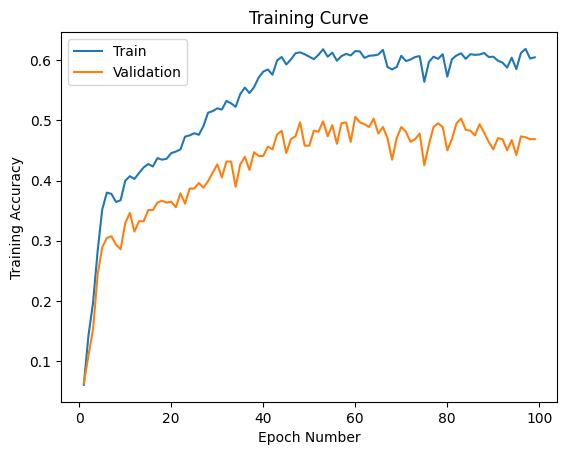

Final Training Accuracy: 0.605072463768116
Final Validation Accuracy: 0.468944099378882
Best Validation Accuracy: 0.5062111801242236


In [ ]:
# Train Output fully connected layers
use_cuda = True
## Apply dropout model
model_v3 = alexNetWithDropOut()
ALNC = alexnet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# keep batch Size to 64
train_with_transfer_learning(model_v3, data_set_folder_train,learning_rate = 0.1, batch_size=64, num_epochs=99)


CUDA is not available.  Training on CPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.17339544513457558 Train Accuracy: 0.13975155279503104, Validation Accuracy: 0.13975155279503104 
Epoch:  2
So Far Best Validation Accuracy: 0.13198757763975155 Train Accuracy: 0.10869565217391304, Validation Accuracy: 0.10869565217391304 
Epoch:  3
So Far Best Validation Accuracy: 0.2013457556935818 Train Accuracy: 0.17701863354037267, Validation Accuracy: 0.17701863354037267 
Epoch:  4
So Far Best Validation Accuracy: 0.2908902691511387 Train Accuracy: 0.2717391304347826, Validation Accuracy: 0.2717391304347826 
Epoch:  5
So Far Best Validation Accuracy: 0.3530020703933747 Train Accuracy: 0.32298136645962733, Validation Accuracy: 0.32298136645962733 
Epoch:  6
So Far Best Validation Accuracy: 0.34834368530020704 Train Accuracy: 0.29347826086956524, Validation Accuracy: 0.29347826086956524 
Epoch:  7
So Far Best Validation Accuracy: 0.432712215320911 Train Accuracy: 0.37577639751552794, Validation 

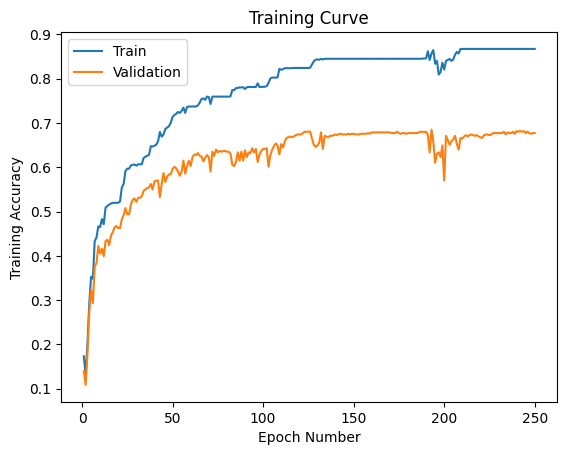

Final Training Accuracy: 0.8669772256728778
Final Validation Accuracy: 0.6770186335403726
Best Validation Accuracy: 0.6847826086956522


In [ ]:
# Use without dropout

model_v4 = classificationWithAlexNet()
ALNC = alexnet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_with_transfer_learning(model_v4, data_set_folder_train,learning_rate = 0.09, batch_size=64, num_epochs=250)

#AlexNet Using Train/Val/Test Split Functions (Version 2)


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
import os


torch.manual_seed(10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')
### Get Dataset ###
PATH = '/content/drive/My Drive/aps360_project_data/small_dataset/small' #TODO Change if Necessary
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
#Normalization is included as part of ENetB2

raw_dataset = torchvision.datasets.ImageFolder(PATH, transform=transform)

### Get Indices ###
NUM_CLASSES = 46 #TODO Change if needed
NUM_DATAPOINTS = 3219 #TODO Change if needed
num_each_class = int(np.ceil(NUM_DATAPOINTS / NUM_CLASSES))
start_points = [0]
for folder in os.listdir(PATH):
    # print(len(os.listdir(PATH+ f"\\{folder}")))
    next = start_points[-1] + len(os.listdir(PATH+f"/{folder}"))
    start_points.append(next)
start_points.pop()
indices = []
for start in start_points:
    next_class_indices = list(range(start,start+num_each_class))
    indices = indices + next_class_indices
# print(len(indices))

### Get Subset of Dataset ###
# raw_subset = torch.utils.data.Subset(raw_dataset, np.arange(num_datapoints)) #This line is wrong - only gets 2 to 3 classes in
# raw_subset = torch.utils.data.Subset(raw_dataset, np.random.choice(len(raw_dataset), NUM_DATAPOINTS, replace=False))
raw_subset = torch.utils.data.Subset(raw_dataset, indices)


############## Code to take the images in order, so the ultimate test is on types of images never before seen in the train ################
# n = len(raw_dataset)
# n_train = int(0.6*n)
# n_val = int(0.8*n)
# train_dataset = torch.utils.data.Subset(raw_dataset, range(n_train))
# val_dataset = torch.utils.data.Subset(raw_dataset, range(n_train, n_val))
# test_dataset = torch.utils.data.Subset(raw_dataset, range(n_val, n+1))
# print("No. Images in train, val, test", len(train_dataset), len(val_dataset), len(test_dataset))


### Get Train/Val/Test Splits ###
n = len(raw_subset)
n_train = int(0.6*n)
n_val = int(0.2*n)
n_test = int(0.2*n)
leftover = n-n_train-n_test-n_val
n_test += leftover
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(raw_subset, [n_train, n_val, n_test])
# print("No. Images in train, val, test", len(train_dataset), len(val_dataset), len(test_dataset))

### Get Data Loaders ###
LOADERS_BATCH_SIZE = 25 #AP #TODO Change if needed
LOADERS_NUM_WORKERS = 2 #AP #TODO Change if needed

train_loader_v2 = torch.utils.data.DataLoader(train_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=0, shuffle=True)


Using cpu for inference


In [ ]:
val_loader_v2 = torch.utils.data.DataLoader(val_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=0, shuffle=True)


In [ ]:
test_loader_v2 = torch.utils.data.DataLoader(test_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=0, shuffle=True)

In [ ]:
import torchvision.models
#load network with trained network
alexnet = torchvision.models.alexnet(pretrained=True)
import numpy as np

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

categories = [
    "airplane",
    "airport",
    "bareland",
    "baseball_diamond",
    "basketball_court",
    "beach",
    "bridge",
    "chaparral",
    "cloud",
    "commercial_area",
    "dense_residential_area",
    "desert",
    "eroded_farmland",
    "farmland",
    "forest",
    "freeway",
    "golf_course",
    "ground_track_field",
    "harbor&port",
    "industrial_area",
    "intersection",
    "island",
    "lake",
    "meadow",
    "mobile_home_park",
    "mountain",
    "overpass",
    "park",
    "parking_lot",
    "parkway",
    "railway",
    "railway_station",
    "river",
    "roundabout",
    "shipping_yard",
    "snowberg",
    "sparse_residential_area",
    "stadium",
    "storage_tank",
    "swimming_pool",
    "tennis_court",
    "terrace",
    "transmission_tower",
    "vegetable_greenhouse",
    "wetland",
    "wind_turbine"
]

In [ ]:
def save_computed_features_v2(dataLoader, path):
 index = 0
 for img, labels in train_loader:
    features = alexnet.features(img)
    features_tensor = features.detach().cpu().numpy()  # Convert to numpy array

    for i, label in enumerate(labels):

        full_path = path + '/' + str(categories[label.item()]) + '/tensor_' + str(index)
        os.makedirs(full_path, exist_ok=True)

        print(full_path)
        torch.save(torch.from_numpy(features_tensor[i]).squeeze(0), full_path + '/' + str(index) + '.tensor')
        index += 1



In [ ]:
alexNet_train_path_small_v2 = '/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train'
alexNet_test_path_small_v2 = '/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test'
alexNet_val_path_small_v2 = '/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val'

##Save features only Once
#save_computed_features_v2(train_loader_v2,alexNet_train_path_small_v2)


/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/mobile_home_park/tensor_0
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/cloud/tensor_1
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/parking_lot/tensor_2
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/park/tensor_3
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/harbor&port/tensor_4
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/snowberg/tensor_5
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/park/tensor_6
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/farmland/tensor_7
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Train/ground_track_field/tensor_8
/content/drive/My Drive/aps360_pr

In [ ]:
#save_computed_features_v2(val_loader_v2,alexNet_test_path_small_v2)


/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/railway_station/tensor_0
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/shipping_yard/tensor_1
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/desert/tensor_2
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/tennis_court/tensor_3
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/storage_tank/tensor_4
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/basketball_court/tensor_5
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/island/tensor_6
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/basketball_court/tensor_7
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Test/freeway/tensor_8
/content/drive/My Drive/

In [ ]:
#save_computed_features_v2(test_loader_v2,alexNet_val_path_small_v2)

/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/dense_residential_area/tensor_0
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/eroded_farmland/tensor_1
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/chaparral/tensor_2
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/airport/tensor_3
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/railway/tensor_4
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/meadow/tensor_5
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/river/tensor_6
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/wetland/tensor_7
/content/drive/My Drive/aps360_project_data/small_dataset/version2BaselineAlexNet/Val/transmission_tower/tensor_8
/content/drive/My Drive/aps360_project_d

In [ ]:
data_set_folder_train_v2 = torchvision.datasets.DatasetFolder(alexNet_train_path_small_v2, loader=torch.load, extensions=('.tensor'))

data_set_folder_val_v2 = torchvision.datasets.DatasetFolder(alexNet_val_path_small_v2, loader=torch.load, extensions=('.tensor'))
data_set_folder_test_v2 = torchvision.datasets.DatasetFolder(alexNet_test_path_small_v2, loader=torch.load, extensions=('.tensor'))

In [ ]:
def train_test_val_Accuracy_v2(model, batch_size, type_of_data = "Train"):
    if (type_of_data == "Train"):
        data = data_set_folder_train_v2
    elif(type_of_data == "Val"):
        data = data_set_folder_val_v2
    elif(type_of_data == "Test"): #Only used to calculate test accuracy at the end
        data = data_set_folder_test_v2 #Will not be used during training as the model should not train on the test dataset

    correct = 0
    total = 0
    use_cuda = True
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_with_transfer_learning_v2(model, data, batch_size=27, learning_rate= 0.0999, num_epochs=30):
    torch.manual_seed(1000) # to ensure consistency in calculations

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss() #Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Use SGD with momentum worked better than Adam Optimizer here
    iters, losses, train_acc,train_err, train_loss, val_acc, val_acc_best = [], [], [], [], [], [], []
    start_time = time.time()

    use_cuda = True

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        val_acc_curr_best = 0

        print("Epoch: ", epoch + 1)
        for imgs, labels in iter(train_loader):
            #Use GPU for faster results
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)            # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            n += 1
            losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(train_test_val_Accuracy_v2(model, batch_size, "Train")) # compute training accuracy
        curr_val_acc =train_test_val_Accuracy_v2(model, batch_size, "Val")
        val_acc.append(curr_val_acc)  # compute validation accuracy
        if (val_acc[-1] > val_acc_curr_best):
            val_acc_curr_best = val_acc[-1]
            val_acc_best.append(val_acc_curr_best) # For particular  Epoch
        total_train_loss += loss.item()
        total_epoch += len(labels)

        print(( "So Far Best Validation Accuracy: {} Train Accuracy: {}, Validation Accuracy: {} ").format(
                   train_acc[-1],
                   val_acc[-1], val_acc_best[-1]))

        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)

    # plotting
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    plt.title("Training Curve")
    plt.plot(range(1, num_epochs + 1), train_acc, label="Train")
    plt.plot(range(1, num_epochs + 1), val_acc, label="Validation")
    plt.xlabel("Epoch Number")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    # Find the epoch with the best val_acc_best[]
    final_best_val_acc = max(val_acc_best)
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Best Validation Accuracy: {}".format(final_best_val_acc))

CUDA is not available.  Training on CPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.11697722567287784 Train Accuracy: 0.11697722567287784, Validation Accuracy: 0.11697722567287784 
Epoch:  2
So Far Best Validation Accuracy: 0.07505175983436853 Train Accuracy: 0.07505175983436853, Validation Accuracy: 0.07505175983436853 
Epoch:  3
So Far Best Validation Accuracy: 0.20652173913043478 Train Accuracy: 0.20652173913043478, Validation Accuracy: 0.20652173913043478 
Epoch:  4
So Far Best Validation Accuracy: 0.2531055900621118 Train Accuracy: 0.2531055900621118, Validation Accuracy: 0.2531055900621118 
Epoch:  5
So Far Best Validation Accuracy: 0.31262939958592134 Train Accuracy: 0.31262939958592134, Validation Accuracy: 0.31262939958592134 
Epoch:  6
So Far Best Validation Accuracy: 0.28209109730848864 Train Accuracy: 0.28209109730848864, Validation Accuracy: 0.28209109730848864 
Epoch:  7
So Far Best Validation Accuracy: 0.32919254658385094 Train Accuracy: 0.32919254658385094, Validat

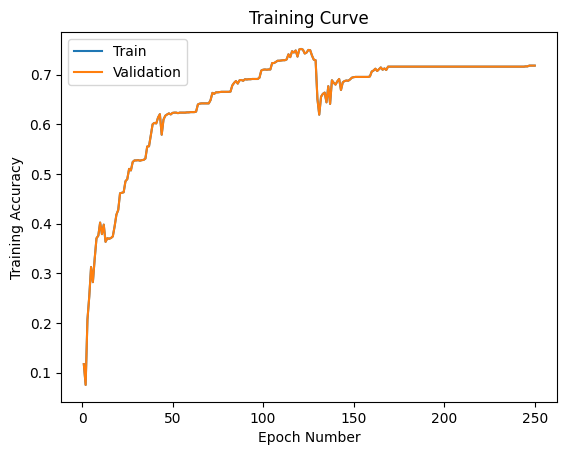

Final Training Accuracy: 0.7184265010351967
Final Validation Accuracy: 0.7184265010351967
Best Validation Accuracy: 0.7520703933747412


In [ ]:
model_v5_version2DataProcessing = classificationWithAlexNet()
ALNC = alexnet.features
use_cuda = True
if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_with_transfer_learning_v2(model_v5_version2DataProcessing, data_set_folder_train_v2,learning_rate = 0.09, batch_size=64, num_epochs=250)

#Version 3 (With 7K dataset and 23 Classes) AlexNet
Using Train/Val/Test split functions

In [ ]:

categories = [
    "baseball_diamond",
    "basketball_court",
    "beach",
    "bridge",
    "commercial_area",
    "dense_residential_area",
    "desert",
    "farmland",
    "forest",
    "freeway",
    "ground_track_field",
    "harbor&port",
    "intersection",
    "island",
    "lake",
    "parking_lot",
    "railway",
    "river",
    "snowberg",
    "sparse_residential_area",
    "stadium",
    "swimming_pool",
    "tennis_court",
]

In [ ]:
# Classification Model After using pre-trained weights for Alexnet
#Now will train the AlexNet Fully connected layers
#Model:
torch.manual_seed(10) # set the random seed
from math import floor

class classificationWithAlexNetModified_v3(nn.Module):
    def __init__(self):
        super(classificationWithAlexNetModified_v3, self).__init__()
        self.name = "classificationWithAlexNetModified_v3"

        self.layer1 = nn.Linear(256*6*6, 190)
        self.layer2 = nn.Linear(190, 98)
        self.layer3 = nn.Linear(98, 23)

    def forward(self, inputImg):
        #print(inputImg.shape)
        flattened_tensor = inputImg.view(-1, 256*6*6)
        layer_first = F.relu(self.layer1(flattened_tensor))
        layer_second = F.relu(self.layer2(layer_first))
        output = self.layer3(layer_second)
        output = output.squeeze(1)
       #output = F.softmax(output)
        return  F.softmax(output, dim=1)
        # Computing the correct input size into the Fully Connected Layer

    '''# for t-SNE
    def featuresTSNE(self, inputImg):
        #print(inputImg.shape)
        flattened_tensor = inputImg.view(-1, 256*6*6)
        layer_first = F.relu(self.layer1(flattened_tensor))
        layer_second = F.relu(self.layer2(layer_first))
        output = self.layer3(layer_second)
        output = output.squeeze(1)
        return output
      '''

In [ ]:
import torchvision.models
#load network with trained network
alexnet = torchvision.models.alexnet(pretrained=True)
import numpy as np


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 130MB/s]


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
import os


torch.manual_seed(10)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
### Get Dataset ###
# Added a shortcut from Shared with Me
PATH = '/content/drive/My Drive/aps360_project_data_shared/Images' #TODO Change if Necessary

transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
#Normalization is included as part of ENetB2

raw_dataset = torchvision.datasets.ImageFolder(PATH, transform=transform)

### Get Indices ###
NUM_CLASSES = 23 #TODO Change if needed
NUM_DATAPOINTS = 7000 #TODO Change if needed
num_each_class = int(np.ceil(NUM_DATAPOINTS / NUM_CLASSES))
start_points = [0]
for folder in os.listdir(PATH):
    # print(len(os.listdir(PATH+ f"\\{folder}")))
    next = start_points[-1] + len(os.listdir(PATH+f"/{folder}"))
    start_points.append(next)
start_points.pop()
indices = []
for start in start_points:
    next_class_indices = list(range(start,start+num_each_class))
    indices = indices + next_class_indices
# print(len(indices))

### Get Subset of Dataset ###
# raw_subset = torch.utils.data.Subset(raw_dataset, np.arange(num_datapoints)) #This line is wrong - only gets 2 to 3 classes in
# raw_subset = torch.utils.data.Subset(raw_dataset, np.random.choice(len(raw_dataset), NUM_DATAPOINTS, replace=False))
raw_subset = torch.utils.data.Subset(raw_dataset, indices)


############## Code to take the images in order, so the ultimate test is on types of images never before seen in the train ################
# n = len(raw_dataset)
# n_train = int(0.6*n)
# n_val = int(0.8*n)
# train_dataset = torch.utils.data.Subset(raw_dataset, range(n_train))
# val_dataset = torch.utils.data.Subset(raw_dataset, range(n_train, n_val))
# test_dataset = torch.utils.data.Subset(raw_dataset, range(n_val, n+1))
# print("No. Images in train, val, test", len(train_dataset), len(val_dataset), len(test_dataset))


### Get Train/Val/Test Splits ###
n = len(raw_subset)
n_train = int(0.6*n)
n_val = int(0.2*n)
n_test = int(0.2*n)
leftover = n-n_train-n_test-n_val
n_test += leftover
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(raw_subset, [n_train, n_val, n_test])
# print("No. Images in train, val, test", len(train_dataset), len(val_dataset), len(test_dataset))

### Get Data Loaders ###
LOADERS_BATCH_SIZE = 25 #AP #TODO Change if needed
LOADERS_NUM_WORKERS = 2 #AP #TODO Change if needed
torch.manual_seed(42)
np.random.seed(42)
train_loader_v3= torch.utils.data.DataLoader(train_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=0, shuffle=True)
val_loader_v3 = torch.utils.data.DataLoader(val_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=0, shuffle=True)
test_loader_v3 = torch.utils.data.DataLoader(test_dataset, batch_size=LOADERS_BATCH_SIZE, num_workers=0, shuffle=True)

In [ ]:
def save_computed_features_v3(train_loader, path):
 index = 0
 for img, labels in train_loader:
    features = alexnet.features(img)
    features_tensor = features.detach().cpu().numpy()  # Convert to numpy array

    for i, label in enumerate(labels):

        folder_name = path + '/' + str(categories[label.item()]) + '/tensor_' + str(index)
        os.makedirs(folder_name, exist_ok=True)

        print(folder_name)
        torch.save(torch.from_numpy(features_tensor[i]).squeeze(0), folder_name + '/' + str(index) + '.tensor')
        index += 1

alexNet_train_path_v3 = '/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet'
alexNet_test_path_v3 = '/content/drive/My Drive/aps360_project_data_shared/TestAlexNet'
alexNet_val_path_v3 = '/content/drive/My Drive/aps360_project_data_shared/ValAlexNet'



In [ ]:
save_computed_features_v3(train_loader_v3,alexNet_train_path_v3)


/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/farmland/tensor_0
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/intersection/tensor_1
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/river/tensor_2
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/sparse_residential_area/tensor_3
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/sparse_residential_area/tensor_4
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/parking_lot/tensor_5
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/farmland/tensor_6
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/stadium/tensor_7
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/river/tensor_8
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/sparse_residential_area/tensor_9
/content/drive/My Drive/aps360_project_data_shared/TrainAlexNet/forest/tensor_10
/content/drive/My Drive/aps360_project_data_shared/Tra

In [ ]:
save_computed_features_v3(val_loader_v3,alexNet_val_path_v3)

/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/basketball_court/tensor_0
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/stadium/tensor_1
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/intersection/tensor_2
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/railway/tensor_3
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/dense_residential_area/tensor_4
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/railway/tensor_5
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/lake/tensor_6
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/stadium/tensor_7
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/dense_residential_area/tensor_8
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/ground_track_field/tensor_9
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/forest/tensor_10
/content/drive/My Drive/aps360_project_data_shared/ValAlexNet/commercial_area/t

In [ ]:
save_computed_features_v3(test_loader_v3,alexNet_test_path_v3)

/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/sparse_residential_area/tensor_0
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/forest/tensor_1
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/beach/tensor_2
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/harbor&port/tensor_3
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/parking_lot/tensor_4
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/bridge/tensor_5
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/stadium/tensor_6
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/harbor&port/tensor_7
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/stadium/tensor_8
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/stadium/tensor_9
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/dense_residential_area/tensor_10
/content/drive/My Drive/aps360_project_data_shared/TestAlexNet/farmland/tensor_1

In [ ]:
data_set_folder_train_v3 = torchvision.datasets.DatasetFolder(alexNet_train_path_v3, loader=torch.load, extensions=('.tensor'))

data_set_folder_val_v3 = torchvision.datasets.DatasetFolder(alexNet_val_path_v3, loader=torch.load, extensions=('.tensor'))
data_set_folder_test_v3 = torchvision.datasets.DatasetFolder(alexNet_test_path_v3, loader=torch.load, extensions=('.tensor'))


In [ ]:

def train_test_val_Accuracy_v3(model, batch_size, type_of_data = "Train"):
    if (type_of_data == "Train"):
        data = data_set_folder_train_v3
    elif(type_of_data == "Val"):
        data = data_set_folder_val_v3
    elif(type_of_data == "Test"): #Only used to calculate test accuracy at the end
        data = data_set_folder_test_v3 #Will not be used during training as the model should not train on the test dataset

    correct = 0
    total = 0
    use_cuda = True
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_with_transfer_learning_v3(model, data, batch_size=27, learning_rate= 0.0999, num_epochs=30):
    torch.manual_seed(1000) # to ensure consistency in calculations

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss() #Cross Entropy Loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Use SGD with momentum worked better than Adam Optimizer here
    iters, losses, train_acc,train_err, train_loss, val_acc, val_acc_best = [], [], [], [], [], [], []
    start_time = time.time()

    use_cuda = True

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        val_acc_curr_best = 0

        print("Epoch: ", epoch + 1)
        for imgs, labels in iter(train_loader):
            #Use GPU for faster results
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)            # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            n += 1
            losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(train_test_val_Accuracy_v3(model, batch_size, "Train")) # compute training accuracy
        curr_val_acc =train_test_val_Accuracy_v3(model, batch_size, "Val")
        val_acc.append(curr_val_acc)  # compute validation accuracy
        if (val_acc[-1] > val_acc_curr_best):
            val_acc_curr_best = val_acc[-1]
            val_acc_best.append(val_acc_curr_best) # For particular  Epoch
        total_train_loss += loss.item()
        total_epoch += len(labels)

        print(( "So Far Best Validation Accuracy: {} Train Accuracy: {}, Validation Accuracy: {} ").format(
                   val_acc_best[-1],
                   train_acc[-1], val_acc[-1]))

        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)

    # plotting
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    plt.title("Training Curve")
    plt.plot(range(1, num_epochs + 1), train_acc, label="Train")
    plt.plot(range(1, num_epochs + 1), val_acc, label="Validation")
    plt.xlabel("Epoch Number")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    # Find the epoch with the best val_acc_best[]
    final_best_val_acc = max(val_acc_best)
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Best Validation Accuracy: {}".format(final_best_val_acc))



CUDA is available!  Training on GPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.1825633383010432 Train Accuracy: 0.16691505216095381, Validation Accuracy: 0.16691505216095381 
Epoch:  2
So Far Best Validation Accuracy: 0.14853452558370592 Train Accuracy: 0.13561847988077497, Validation Accuracy: 0.13561847988077497 
Epoch:  3
So Far Best Validation Accuracy: 0.2677595628415301 Train Accuracy: 0.2459016393442623, Validation Accuracy: 0.2459016393442623 
Epoch:  4
So Far Best Validation Accuracy: 0.33358171882762044 Train Accuracy: 0.30327868852459017, Validation Accuracy: 0.30327868852459017 
Epoch:  5
So Far Best Validation Accuracy: 0.36835568802781915 Train Accuracy: 0.3360655737704918, Validation Accuracy: 0.3360655737704918 
Epoch:  6
So Far Best Validation Accuracy: 0.4642324888226528 Train Accuracy: 0.4314456035767511, Validation Accuracy: 0.4314456035767511 
Epoch:  7
So Far Best Validation Accuracy: 0.47590660705414806 Train Accuracy: 0.4485842026825633, Validation Accurac

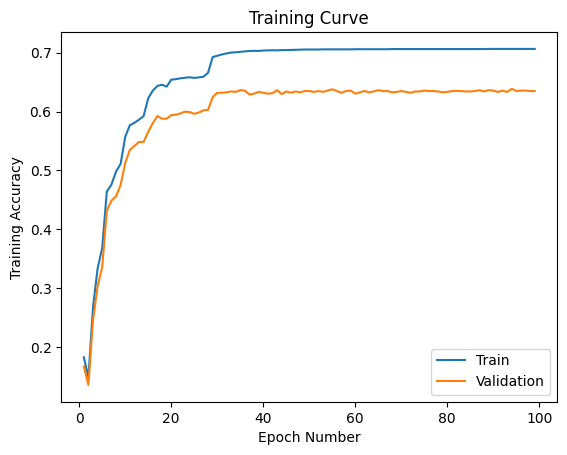

Final Training Accuracy: 0.706408345752608
Final Validation Accuracy: 0.6348733233979136
Best Validation Accuracy: 0.6385991058122206


In [ ]:
model_v7_version3DataProcessing = classificationWithAlexNetModified_v3()
ALNC = alexnet.features
use_cuda = True
if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model_v7_version3DataProcessing.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_with_transfer_learning_v3(model_v7_version3DataProcessing, data_set_folder_train_v3,learning_rate = 0.009, batch_size=64, num_epochs=99)

CUDA is available!  Training on GPU ...
Epoch:  1
So Far Best Validation Accuracy: 0.13561847988077497 Train Accuracy: 0.14754098360655737, Validation Accuracy: 0.13561847988077497 
Epoch:  2
So Far Best Validation Accuracy: 0.1497764530551416 Train Accuracy: 0.15548931942374566, Validation Accuracy: 0.1497764530551416 
Epoch:  3
So Far Best Validation Accuracy: 0.09910581222056632 Train Accuracy: 0.10531544957774466, Validation Accuracy: 0.09910581222056632 
Epoch:  4
So Far Best Validation Accuracy: 0.09016393442622951 Train Accuracy: 0.09413810233482364, Validation Accuracy: 0.09016393442622951 
Epoch:  5
So Far Best Validation Accuracy: 0.1631892697466468 Train Accuracy: 0.1780923994038748, Validation Accuracy: 0.1631892697466468 
Epoch:  6
So Far Best Validation Accuracy: 0.19374068554396423 Train Accuracy: 0.20938897168405365, Validation Accuracy: 0.19374068554396423 
Epoch:  7
So Far Best Validation Accuracy: 0.2436661698956781 Train Accuracy: 0.2593144560357675, Validation Accu

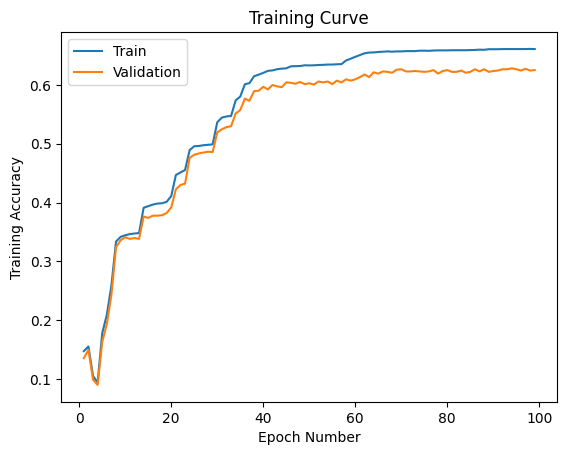

Final Training Accuracy: 0.6609538002980626
Final Validation Accuracy: 0.6251862891207154
Best Validation Accuracy: 0.6281669150521609


In [ ]:
model_v8_version3DataProcessing = classificationWithAlexNetModified_v3()
ALNC = alexnet.features
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model_v8_version3DataProcessing.cuda()
  ALNC.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_with_transfer_learning_v3(model_v8_version3DataProcessing, data_set_folder_train_v3,learning_rate = 0.003, batch_size=64, num_epochs=99)

#Save the Best Model

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
model_path = get_model_name(model_v5_version2DataProcessing.name, batch_size=64, learning_rate= 0.09, epoch=250)
torch.save(model_v5_version2DataProcessing.state_dict(), model_path)

#Test the AlexNet Model

In [ ]:
test_accuracy_AlexNet = train_test_val_Accuracy_v2(model_v5_version2DataProcessing, batch_size=64, type_of_data = "Test")

print("Test accuracy for AlexNet: ",test_accuracy_AlexNet*100, "%")

Test accuracy for AlexNet:  71.84265010351967 %


# Visualize Kernals

In [ ]:
'''
# Visualize some sample data
x = torch.from_numpy(img) # turn img into a PyTorch tensor
print(x.shape)
x = x.permute(2,0,1)      # move the channel dimension to the beginning
features = alexNet.features(x)
features.shape
x = x.reshape([1, 3, 350, 210]) # add a dimension for batching
print(x.shape) #4D tensor
features = alexNet.features(x)
features.shape

alexNetConv = alexnet.features[0] # First conv layer
y = alexNetConv(x) # apply image on layer, 1st layer has 64 channels as output
y.shape

y = y.detach().numpy() # output to numpy
y = (y - y.min()) / (y.max() - y.min()) #normalize between 0 and 1 to plot
y.shape

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i])

#each feature map is detecting something. Edges 2nd one top row..
#these feature map trained on different dataset, they are still detecting from our new image
'''
# obtain one batch of training images
train_data_loader = torch.utils.data.DataLoader(data_set_folder_train, batch_size=256,
                                           num_workers=0, shuffle=True)
'''
dataiter = iter(train_data_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    arr = np.transpose(images[idx],(1, 2, 0))
    plt.imshow(arr)
    ax.set_title(categories[labels[idx]])
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

'''
# Assuming train_data_loader is your DataLoader object and dataiter is correctly defined
dataiter = iter(train_data_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(224, 224))
num_images = images.shape[0]
for idx in np.arange(num_images):
    ax = fig.add_subplot(2, num_images//2, idx+1, xticks=[], yticks=[])

    sample = images[idx].reshape((96, 96))

    plt.imshow(sample)
    ax.set_title(categories[labels[idx]])

plt.show()


The baseline Model AlexNet is Combined with AMF and SVM:

Order:
AMF (to help create high-resolution images), Pre-trained AlexNet Model Weights + Train Fully Connected Layers of AlexNet Classification + SVM




#SVM (Support Vector Machines)

In [ ]:
from sklearn import svm

In [ ]:
classify_with_SVM = svm.SVC(kernel='linear', gamma='auto', C=2)

import os

class_index = {
    'airplane': 0,
    'airport': 1,
    'bareland': 2,
    'baseball_diamond': 3,
    'basketball_court': 4,
    'beach': 5,
    'bridge': 6,
    'chaparral': 7,
    'cloud': 8,
    'commercial_area': 9,
    'dense_residential_area': 10,
    'desert': 11,
    'eroded_farmland': 12,
    'farmland': 13,
    'forest': 14,
    'freeway': 15,
    'golf_course': 16,
    'ground_track_field': 17,
    'harbor&port': 18,
    'industrial_area': 19,
    'intersection': 20,
    'island': 21,
    'lake': 22,
    'meadow': 23,
    'mobile_home_park': 24,
    'mountain': 25,
    'overpass': 26,
    'park': 27,
    'parking_lot': 28,
    'parkway': 29,
    'railway': 30,
    'railway_station': 31,
    'river': 32,
    'roundabout': 33,
    'shipping_yard': 34,
    'stadium': 35,
    'swimming_pool': 36,
    'tennis_court': 37,
    'terrace': 38,
    'transmission_tower': 39,
    'vegetable_greenhouse': 40,
    'wetland': 41,
    'wind_turbine': 42
}


In [ ]:

val_data_loader = torch.utils.data.DataLoader(data_set_folder_val, batch_size=64,
                                           num_workers=0, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(data_set_folder_test, batch_size=64,
                                           num_workers=0, shuffle=True)

input_Features_train, train_labels = [], []
# Train data_loader contains features
for features, labels in train_data_loader:
    array_of_labels = labels.numpy()
    train_labels.extend(array_of_labels)
    numpy_features = features.numpy()
    input_Features_train.append(numpy_features)

input_Features_test, test_labels = [], []

for features, labels in test_data_loader:
    array_of_labels = labels.numpy()
    test_labels.extend(array_of_labels)
    numpy_features = features.numpy()
    input_Features_test.append(numpy_features)

X_train = np.concatenate(input_Features_train, axis=0)
train_labels_output = np.array(train_labels)

first_dim = X_train.shape[0]
flatten_Image_Features = X_train.reshape(first_dim, -1)
input_features_test = np.concatenate(input_Features_test, axis=0)
output_test_arr = np.array(test_labels)

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


Input_train_flat, validation_flat_input, out_train, out_validation = train_test_split(flatten_Image_Features, train_labels_output, test_size=0.2, random_state=42)

stdScale = StandardScaler()

transform_input_train = stdScale.fit_transform(Input_train_flat)
trasform_input_val = stdScale.transform(validation_flat_input)

# Use a classifier
classification_with_svm = SVC(kernel='linear', C=1.0)
#"train" the classifer SVM the pretrained alexnet features that were flattened
classification_with_svm.fit(transform_input_train, out_train)

# get validation output
prediction_val_output = classification_with_svm.predict(trasform_input_val)
# compute validation accuracy using a pre-built function in the library

val_accuracy = accuracy_score(out_validation, prediction_val_output)
print("SVM Validation Accuracy:", val_accuracy )

first_dim_input_feature = input_features_test.shape[0]

flattend_input_test = input_features_test.reshape(first_dim_input_feature, -1)

prediction_test_output = classification_with_svm.predict(stdScale.transform(flattend_input_test))

test_accuracy = accuracy_score(output_test_arr, prediction_test_output)
print("SVM Test Accuracy: ", test_accuracy)




SVM Validation Accuracy: 0.8578811369509044
SVM Test Accuracy:  0.7884914463452566


For the larger Dataset used:

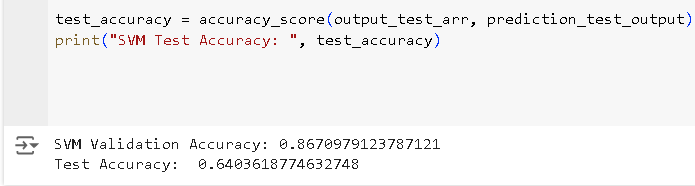

In [ ]:
'''# t-SNE
from sklearn.manifold import TSNE

# extract features
feature_list = []

for img, labels in val_data_loader:
  features = model.extract_features(imgs)
  feature_list.append(features)

features_ten = torch.cat(feature_list) # convert to tensor
features_np = features_ten.numpy()

tsne = TSNE(n_components = 2, random_state = 42)
tsne = tsne.fit_transform(features_np)

plot.figure(figsize =(10, 8))
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.title('t-SNE visualization of final fully connected layer')
plt.show()
'''

#SVM model (for version 3: 7K dataset and 23 classes)

Run this section separately (eg. SVM model small dataset with its corresponding confusion matrix code and SVM model 7k dataset with its corresponding confusion matrix code)


In [ ]:
from sklearn import svm
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import os

In [ ]:

classify_with_SVM = svm.SVC(kernel='linear', gamma='auto', C=2)
# set the cost to 2
# kernal is linear for now
class_index = {
    "baseball_diamond": 0,
    "basketball_court": 1,
    "beach": 2,
    "bridge": 3,
    "commercial_area": 4,
    "dense_residential_area": 5,
    "desert": 6,
    "farmland": 7,
    "forest": 8,
    "freeway": 9,
    "ground_track_field": 10,
    "harbor&port": 11,
    "intersection": 12,
    "island": 13,
    "lake": 14,
    "parking_lot": 15,
    "railway": 16,
    "river": 17,
    "snowberg": 18,
    "sparse_residential_area": 19,
    "stadium": 20,
    "swimming_pool": 21,
    "tennis_court": 22
}

train_data_loader_v3 = torch.utils.data.DataLoader(data_set_folder_train_v3, batch_size=64,
                                           num_workers=0, shuffle=True)
val_data_loader_v3 = torch.utils.data.DataLoader(data_set_folder_val_v3, batch_size=64,
                                           num_workers=0, shuffle=True)
test_data_loader_v3 = torch.utils.data.DataLoader(data_set_folder_test_v3, batch_size=64,
                                           num_workers=0, shuffle=True)

input_Features_train, train_labels = [], []
# Train data_loader contains features
for features, labels in train_data_loader_v3:
    array_of_labels = labels.numpy()
    train_labels.extend(array_of_labels)
    numpy_features = features.numpy()
    input_Features_train.append(numpy_features)

input_Features_test, test_labels = [], []

for features, labels in test_data_loader_v3:
    array_of_labels = labels.numpy()
    test_labels.extend(array_of_labels)
    numpy_features = features.numpy()
    input_Features_test.append(numpy_features)

X_train = np.concatenate(input_Features_train, axis=0)
train_labels_output = np.array(train_labels)

first_dim = X_train.shape[0]
flatten_Image_Features = X_train.reshape(first_dim, -1)
input_features_test = np.concatenate(input_Features_test, axis=0)
output_test_arr = np.array(test_labels)




Input_train_flat, validation_flat_input, out_train, out_validation = train_test_split(flatten_Image_Features, train_labels_output, test_size=0.2, random_state=42)

stdScale = StandardScaler()

transform_input_train = stdScale.fit_transform(Input_train_flat)
trasform_input_val = stdScale.transform(validation_flat_input)

# Use a classifier
classification_with_svm = SVC(kernel='linear', C=1.0)
#"train" the classifer SVM the pretrained alexnet features that were flattened
classification_with_svm.fit(transform_input_train, out_train)

# get validation output
prediction_val_output = classification_with_svm.predict(trasform_input_val)
# compute validation accuracy using a pre-built function in the library

val_accuracy = accuracy_score(out_validation, prediction_val_output)
print("SVM Validation Accuracy:", val_accuracy )

first_dim_input_feature = input_features_test.shape[0]

flattend_input_test = input_features_test.reshape(first_dim_input_feature, -1)

prediction_test_output = classification_with_svm.predict(stdScale.transform(flattend_input_test))



SVM Validation Accuracy: 0.892059553349876


In [ ]:
test_accuracy = accuracy_score(output_test_arr, prediction_test_output)
print("SVM Test Accuracy: ", test_accuracy)

SVM Test Accuracy:  0.9046199701937406


In [ ]:
print(output_test_arr)
print(prediction_test_output)
import matplotlib.pyplot as plt
import numpy as np

[ 0 16  3 ...  0  8 16]
[ 0 16  3 ... 16  8 16]


#The Confusion Matrix for the Baseline Model

Version 1: SVM model with 46 Classes (small and full_size dataset)

Confusion Matrix:
[[ 5  1  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  1 ...  0  0 13]]


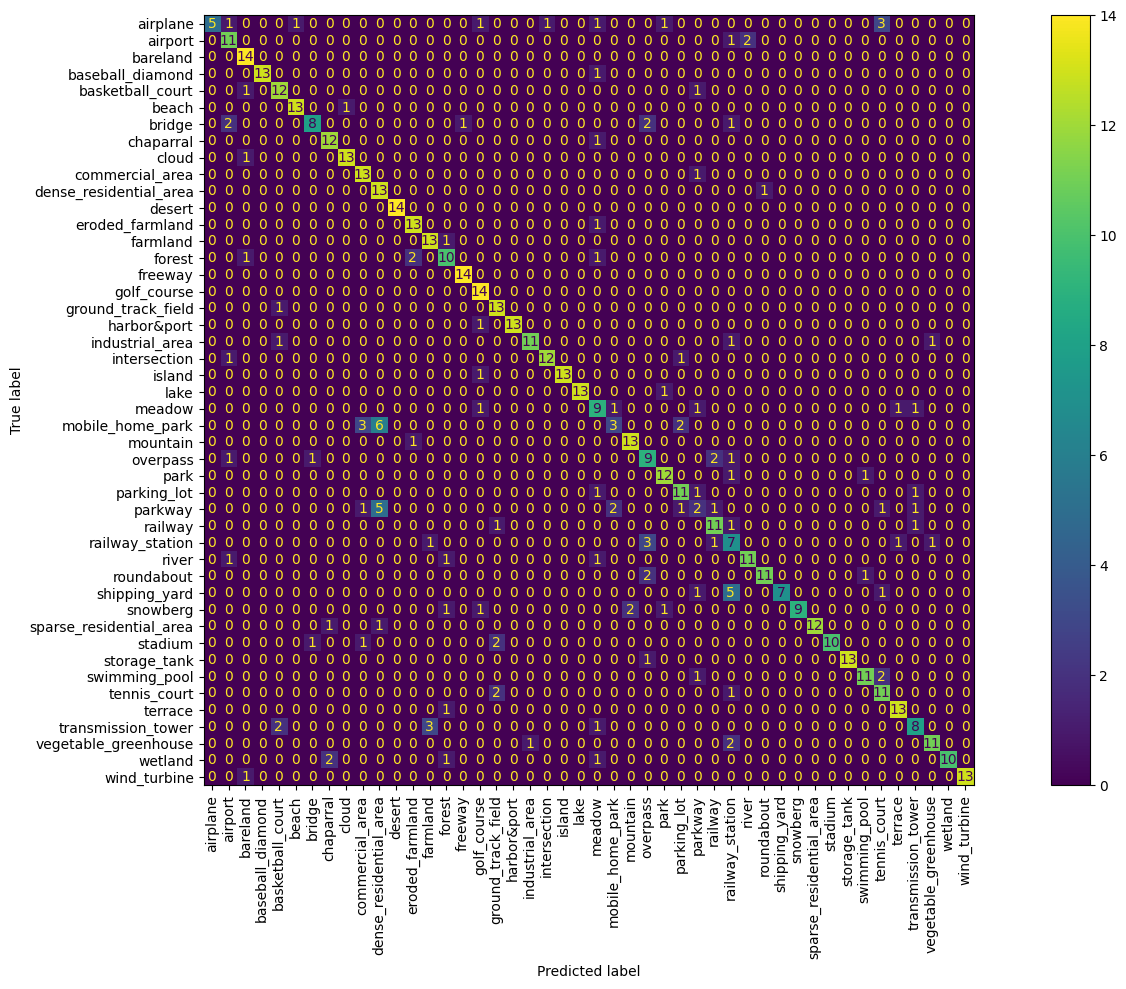

'\ndisp.plot()\nplt.show()\n'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



cm = confusion_matrix(output_test_arr, prediction_test_output)
print("Confusion Matrix:")
print (cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    "airplane",
    "airport",
    "bareland",
    "baseball_diamond",
    "basketball_court",
    "beach",
    "bridge",
    "chaparral",
    "cloud",
    "commercial_area",
    "dense_residential_area",
    "desert",
    "eroded_farmland",
    "farmland",
    "forest",
    "freeway",
    "golf_course",
    "ground_track_field",
    "harbor&port",
    "industrial_area",
    "intersection",
    "island",
    "lake",
    "meadow",
    "mobile_home_park",
    "mountain",
    "overpass",
    "park",
    "parking_lot",
    "parkway",
    "railway",
    "railway_station",
    "river",
    "roundabout",
    "shipping_yard",
    "snowberg",
    "sparse_residential_area",
    "stadium",
    "storage_tank",
    "swimming_pool",
    "tennis_court",
    "terrace",
    "transmission_tower",
    "vegetable_greenhouse",
    "wetland",
    "wind_turbine"
]
)
figure, axis = plt.subplots(figsize=(20, 10))
disp.plot(ax=axis)
plt.xticks(rotation=90)

plt.show()
'''
disp.plot()
plt.show()
'''

## Confusion Matrix for Version 3 (7k dataset + 23 Classes)


Confusion Matrix:
[[ 47   1   0   0   0   0   0   0   0   1   0   0   1   0   0   0   1   0
    1   0   2]
 [  0  53   0   2   0   0   0   0   0   1   0   0   0   0   0   2   1   0
    2   0   1]
 [  0   2  71   0   0   0   1   0   0   0   0   0   0   0   0   0   1   0
    0   0   0]
 [  0   1   0 102   3   0   0   0   0   0   0   1   0   0   0   3   0   0
    0   0   0]
 [  0   0   0   4  58   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0  64   1   0   0   0   0   0   0   1   0   0   0   0
    0   0   0]
 [  0   0   0   0   0   0  21   0   0   0   0   0   0   0   0   2   1   0
    0   0   2]
 [  0   0   0   0   0   0   2  37   0   0   0   0   0   0   0   0   1   0
    0   0   0]
 [  0   1   0   0   0   0   0   0  66   0   0   0   0   0   0   6   0   0
    0   0   0]
 [  0   4   0   0   0   0   0   0   0  56   0   0   0   0   0   0   0   0
    1   0   0]
 [  0   0   0   2   2   0   0   0   0   0  46   0   0   0   0   0   1   0
    0   0   0]
 [ 

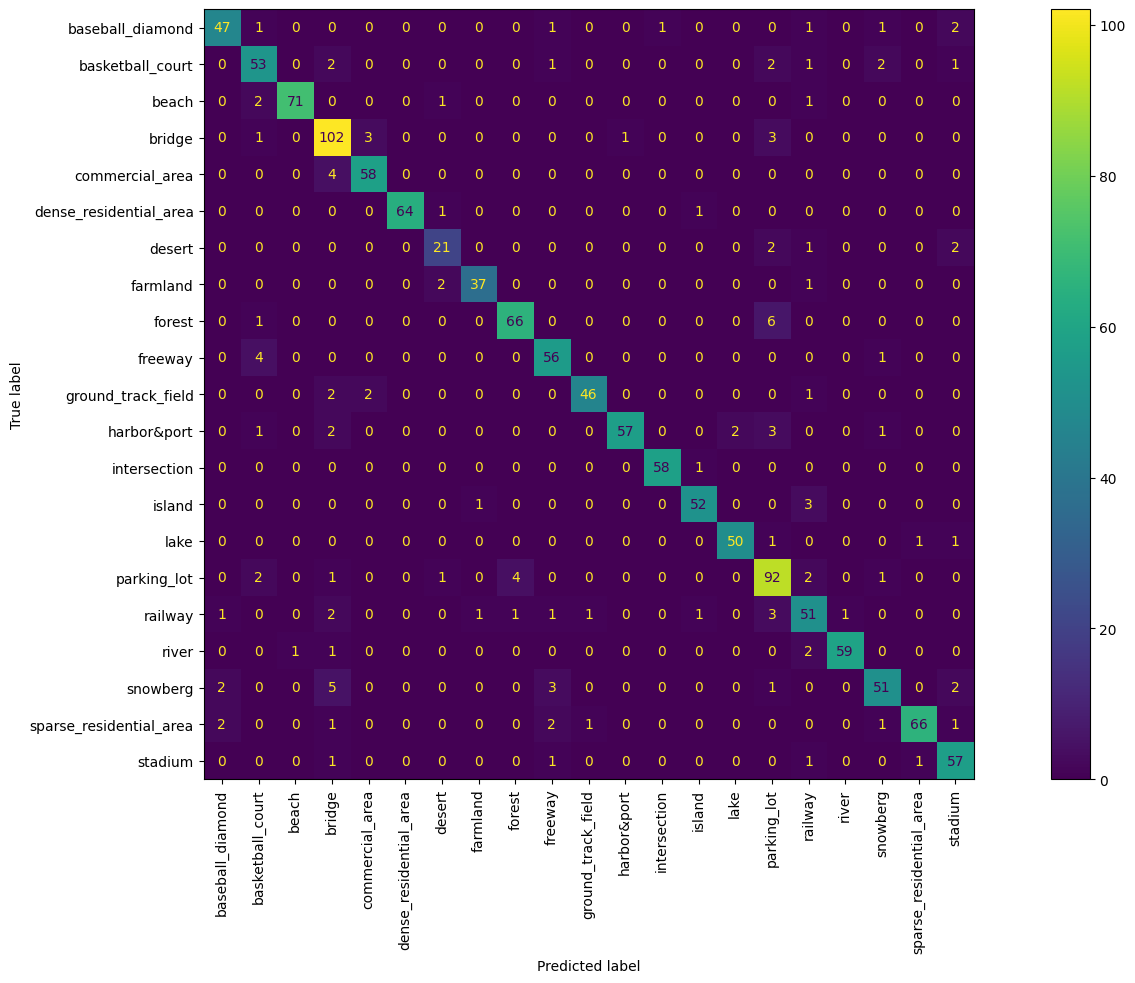

'\ndisp.plot()\nplt.show()\n'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Here only 20 classes shown for simplicity

cm = confusion_matrix(output_test_arr, prediction_test_output)
print("Confusion Matrix:")
print (cm)
print(len(output_test_arr), len(prediction_test_output))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [
    "baseball_diamond",
    "basketball_court",
    "beach",
    "bridge",
    "commercial_area",
    "dense_residential_area",
    "desert",
    "farmland",
    "forest",
    "freeway",
    "ground_track_field",
    "harbor&port",
    "intersection",
    "island",
    "lake",
    "parking_lot",
    "railway",
    "river",
    "snowberg",
    "sparse_residential_area",
    "stadium"
]
)
figure, axis = plt.subplots(figsize=(20, 10))
disp.plot(ax=axis)
plt.xticks(rotation=90)

plt.show()
'''
disp.plot()
plt.show()
'''

#Final Model Backend Testing

In [ ]:
path = '/content/model_pretrained_epochs15_lr0.001.pth'
state_dict = torch.load(path)
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

model_test = torchvision.models.efficientnet_b2(weights=None)
for params in model_test.parameters():
        params.requires_grad = False
model_test.trainable = False
NUM_CLASSES = 22
model_test.classifier[1] = nn.Linear(in_features=1408, out_features=NUM_CLASSES) ##########################AP1408/1280############################
checkpoint = torch.load(path)
model_test.load_state_dict(checkpoint['model_state_dict'])
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])


In [ ]:
img = Image.open("beach_02499.jpg")
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0)
outputs = model_test(input_batch)

In [ ]:
print(outputs)

tensor([[-5.9781, -4.6692, -6.5449, -5.1400, -7.1254, -7.8522, -4.5946, -6.4563,
         -5.9891, -4.5821, -5.2849, -5.9906, -6.5660, -4.9243, -6.1800, -5.0394,
         -5.5535, -6.7022, -6.6021, -4.4784, -6.4758, -4.3744]],
       grad_fn=<AddmmBackward0>)


In [ ]:
outputs.shape

torch.Size([1, 22])

In [ ]:

probabilities = torch.nn.functional.softmax(output, dim=1)
max_index = np.argmax(probabilities)

# FrontEnd Integration with the Backend (model)

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
print(model.summary)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np



553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
<bound method Model.summary of <Functional name=vgg16, built=True>>


In [ ]:
!pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Use anvil uplink ( and pip install)
# connect to anvil app

import anvil.server
anvil.server.connect("server_25V5ANMGYD6IJTK5XJZB3FB4-PZTN2ZSXEZ5ADGYZ")



Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
import anvil.server
from PIL import Image
import torch
import torchvision.models as models
from torchvision import transforms
import numpy as np

# Load the pre-trained EfficientNet B2 model
model = models.efficientnet_b2(weights="DEFAULT")

# Modify the final layer to match the number of classes (22)
NUMCLASSES = 22
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUMCLASSES)

# Load the state dictionary
path = '/content/model_pretrained_epochs15_lr0.001.pth'
checkpoint = torch.load(path)
state_dict = checkpoint['model_state_dict']  # Extract the model's state dictionary

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = Image.open(filename)
        img = img.resize((224, 224), resample=Image.BICUBIC)
        input = transform(img)
        input_with_one_batch = input.unsqueeze(0)
        with torch.no_grad():
            output = model(input_with_one_batch)

        prob_with_class_index = torch.nn.functional.softmax(output, dim=1)

        max_index = np.argmax(prob_with_class_index.cpu().numpy())

        classes = [
            "baseball_diamond",
            "basketball_court",
            "beach",
            "bridge",
            "commercial_area",
            "dense_residential_area",
            "desert",
            "farmland",
            "forest",
            "freeway",
            "ground_track_field",
            "harbor&port",
            "intersection",
            "island",
            "lake",
            "parking_lot",
            "railway",
            "river",
            "snowberg",
            "sparse_residential_area",
            "stadium",
            "swimming_pool",
            "tennis_court",
        ]

        return classes[max_index]

# Example usage in Anvil
anvil.server.wait_forever()

KeyboardInterrupt: 